In [1]:
import json
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import json
with open('./data/docred/valid_revise.json', 'r') as fh:
    revise_dataset  = json.load(fh)
with open('./data/docred/valid_scratch.json', 'r') as fh:
    scratch_dataset = json.load(fh)
with open('./data/docred/valid_recommend.json', 'r') as fh:
    recommend_dataset = json.load(fh)

In [9]:
max_sent_dis, min_sent_dis = [], []
miss_max_sent_dis, miss_min_sent_dis = [], []


head_sent_first, head_sent_last = [], []
tail_sent_first, tail_sent_last = [], []
miss_head_sent_first, miss_head_sent_last = [], []
miss_tail_sent_first, miss_tail_sent_last = [], []

sent_head_behind_tail, sent_tail_behind_head, miss_sent_head_behind_tail, miss_sent_tail_behind_head = 0, 0, 0, 0


for recommend_data, revise_data, scratch_data in zip(recommend_dataset, revise_dataset, scratch_dataset):
    human_pos = set()
    for label in revise_data['labels']:
        human_pos.add((label['h'], label['t'], label['r']))
    ds_pos = [(label['h'], label['t'], label['r']) for label in recommend_data['labels']]
    human_ds = set(human_pos) - set(ds_pos)

    scratch_pos = [(label['h'], label['t'], label['r']) for label in scratch_data['labels']]
    miss_pos = set(scratch_pos) - set(human_pos)
    # Sent offset:
    cur_offset = 0
    sent_offset = []
    for sent in scratch_data['sents']:
        sent_offset.append(cur_offset)
        cur_offset += len(sent)
    
    # distance num between head and tail entities
    all_ent_pos = {}
    for e_idx, nodes in enumerate(scratch_data['vertexSet']):
        ent_pos = {'word_pos': set(), 'sent_pos': set()}
        for node in nodes:
            ent_pos['sent_pos'].add(node['sent_id'])
            ent_pos['word_pos'].add(sent_offset[node['sent_id']] + node['pos'][0])
        all_ent_pos[e_idx] = ent_pos

    ent_pair_dis = {}
    for e_idx1, ent_pos1 in all_ent_pos.items():
        for e_idx2, ent_pos2 in all_ent_pos.items():
            if e_idx1 == e_idx2:
                continue
            word_dis = [w_pos1 - w_pos2 for w_pos1 in ent_pos1['word_pos'] for w_pos2 in ent_pos2['word_pos']]
            abs_word_dis = np.abs(word_dis)
            sent_dis = [s_pos1 - s_pos2 for s_pos1 in ent_pos1['sent_pos'] for s_pos2 in ent_pos2['sent_pos']]
            abs_sent_dis = np.abs(sent_dis)
            ent_pair_dis[(e_idx1, e_idx2)] = {
                'word_dis': word_dis,
                'abs_word_dis': abs_word_dis,
                'sent_dis': sent_dis,
                'abs_sent_dis': abs_sent_dis,
            }
    
    for label in human_ds:
        dis = ent_pair_dis[(label[0], label[1])]
        head_pos, tail_pos = all_ent_pos[label[0]], all_ent_pos[label[1]]


        max_sent_dis.append(max(dis['abs_sent_dis']))
        min_sent_dis.append(min(dis['abs_sent_dis']))

        head_sent_first.append(min(head_pos['sent_pos']))
        head_sent_last.append(max(head_pos['sent_pos']))
        tail_sent_first.append(min(tail_pos['sent_pos']))
        tail_sent_last.append(max(tail_pos['sent_pos']))

        if min(head_pos['sent_pos']) > max(tail_pos['sent_pos']):
            sent_head_behind_tail += 1

        if min(tail_pos['sent_pos']) > max(head_pos['sent_pos']):
            sent_tail_behind_head += 1

    for label in miss_pos:
        if label[0] == label[1]:
            continue
        dis = ent_pair_dis[(label[0], label[1])]
        head_pos, tail_pos = all_ent_pos[label[0]], all_ent_pos[label[1]]

        miss_max_sent_dis.append(max(dis['abs_sent_dis']))
        miss_min_sent_dis.append(min(dis['abs_sent_dis']))

        miss_head_sent_first.append(min(head_pos['sent_pos']))
        miss_head_sent_last.append(max(head_pos['sent_pos']))
        miss_tail_sent_first.append(min(tail_pos['sent_pos']))
        miss_tail_sent_last.append(max(tail_pos['sent_pos']))

        if min(head_pos['sent_pos']) > max(tail_pos['sent_pos']):
            miss_sent_head_behind_tail += 1

        if min(tail_pos['sent_pos']) > max(head_pos['sent_pos']):
            miss_sent_tail_behind_head += 1

    

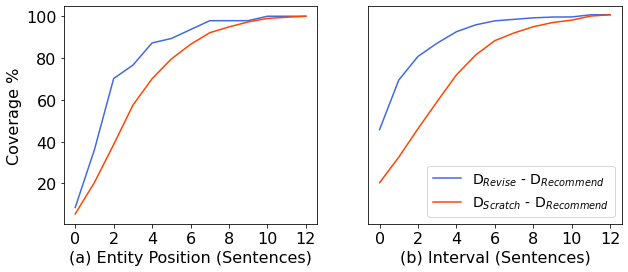

In [17]:
fig=plt.figure(figsize=(10,4))

colors=['orangered', 'royalblue', 'orangered', 'royalblue']

ax=fig.add_subplot(121)
miss_head_tail_sent_first = np.array(miss_head_sent_first) + np.array(miss_tail_sent_first)
head_tail_sent_first = np.array(head_sent_first) + np.array(tail_sent_first)

miss_head_tail_sent_last = np.array(miss_head_sent_last) + np.array(miss_tail_sent_last)
head_tail_sent_last = np.array(head_sent_last) + np.array(tail_sent_last)

miss_head_tail_sent_first = miss_head_tail_sent_first / 2
head_tail_sent_first = head_tail_sent_first / 2
miss_head_tail_sent_last = miss_head_tail_sent_last / 2
head_tail_sent_last = head_tail_sent_last / 2

stats = [miss_head_tail_sent_first, head_tail_sent_first, miss_head_tail_sent_last, head_tail_sent_last]
fmts = ['r--', 'b--', 'r', 'b']
bin_max = 12
bin_size = 1
bound = 12

for idx in [3, 2]:
    s = pd.Series(stats[idx])
    bin_stats = s.groupby(pd.cut(s, bins=list(range(-1, bin_max, bin_size)) + [10000])).count() / len(stats[idx]) * 100
    per, x, y = 0, [], []   
    for k, v in bin_stats.items():
        if k.right == 10000:
            x.append(bound)
        else:
            x.append(k.right)
        per += v
        y.append(per)
    ax.plot(x, y, fmts[idx], color=colors[idx])
ax.set_xlabel("(a) Entity Position (Sentences)", fontsize=16)
ax.set_ylabel("Coverage %", fontsize=16)
labels = ax.get_xticklabels() + ax.get_yticklabels()
_ = [label.set_fontsize(16) for label in labels]
################################################

# ax=fig.add_subplot(142)
# miss_head_tail_sent_first_per = np.array(miss_head_sent_first_per) + np.array(miss_tail_sent_first_per)
# head_tail_sent_first_per = np.array(head_sent_first_per) + np.array(tail_sent_first_per)

# miss_head_tail_sent_last_per = np.array(miss_head_sent_last_per) + np.array(miss_tail_sent_last_per)
# head_tail_sent_last_per = np.array(head_sent_last_per) + np.array(tail_sent_last_per)
# miss_head_tail_sent_first_per /= 2
# head_tail_sent_first_per /= 2
# miss_head_tail_sent_last_per /= 2
# head_tail_sent_last_per /= 2

# stats = [miss_head_tail_sent_first_per, head_tail_sent_first_per, miss_head_tail_sent_last_per, head_tail_sent_last_per]
# fmts = ['r--', 'b--', 'r', 'b']
# bin_max = 100
# bin_size = 10
# bound = 100

# for idx in [2, 3]:
#     s = pd.Series(stats[idx])
#     bin_stats = s.groupby(pd.cut(s, bins=list(range(-1, bin_max, bin_size)) + [10000])).count() / len(stats[idx]) * 100
#     per, x, y = 0, [], []   
#     for k, v in bin_stats.items():
#         if k.right == 10000:
#             x.append(bound)
#         else:
#             x.append(k.right)
#         per += v
#         y.append(per)
#     ax.plot(x, y, fmts[idx], color=colors[idx])
# ax.set_xlabel("(b) Relative Entity Position (%)", fontsize=16)
# labels = ax.get_xticklabels() + ax.get_yticklabels()
# _ = [label.set_fontsize(16) for label in labels]
##################################################################

ax=fig.add_subplot(122)
stats = [miss_max_sent_dis, miss_min_sent_dis, max_sent_dis, min_sent_dis]
labels = ["D$_{Scratch}$ - D$_{Recommend}$", "D$_{Revise}$ - D$_{Recommend}$", ]
fmts = ['r', 'b', 'r', 'b']
bin_max = 12
bin_size = 1
bound = 12

for idx in [1, 0]:
    s = pd.Series(stats[idx])
    bin_stats = s.groupby(pd.cut(s, bins=list(range(-1, bin_max, bin_size)) + [10000])).count() / len(stats[idx]) * 100
    per, x, y = 0, [], []   
    for k, v in bin_stats.items():
        if k.right == 10000:
            x.append(bound)
        else:
            x.append(k.right)
        per += v
        y.append(per)
    ax.plot(x, y, fmts[idx], label=labels[idx], color=colors[idx])
ax.set_yticks(range(0,120, 20))

ax.set_xlabel("(b) Interval (Sentences)", fontsize=16)
labels = ax.get_xticklabels() + ax.get_yticklabels()
_ = [label.set_fontsize(16) for label in labels]

##############################
# ax=fig.add_subplot(144)
# miss_h_t_freq = (np.array(miss_h_freq) + np.array(miss_t_freq)) / 2
# h_t_freq = (np.array(h_freq) + np.array(t_freq)) / 2
# stats = [miss_h_t_freq, h_t_freq]
# labels=['$D_{Scratch} - D_{Recommend}$', '$D_{Revise} - D_{Recommend}$']
# fmts = ['r', 'b']
# bin_max = 12
# bin_size = 1
# bound = 12

# for idx in [1,0]:
#     s = pd.Series(stats[idx])
#     bin_stats = s.groupby(pd.cut(s, bins=list(range(0, bin_max, bin_size)) + [10000])).count() / len(stats[idx]) * 100
#     per, x, y = 0, [], []   
#     for k, v in bin_stats.items():
#         if k.right == 10000:
#             x.append(bound)
#         else:
#             x.append(k.right)
#         per += v
#         y.append(per)
#     ax.plot(x, y, fmts[idx], label=labels[idx], color=colors[idx])

# ax.set_xlabel("(d) Entity Frenquency", fontsize=16)
# labels = ax.get_xticklabels() + ax.get_yticklabels()
# _ = [label.set_fontsize(16) for label in labels]
ax.legend(loc='center right', bbox_to_anchor=(1., 0.15), ncol=1, fontsize=14)
ax.set_yticks([])


fig.subplots_adjust(hspace=0.3)
fig.savefig('./figs/entity_analysis.pdf', bbox_inches='tight')
